# Transfer Learning

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.



# Imports


In [ ]:
import tensorflow as tf

In [ ]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Using a TensorFlow Hub MobileNet for prediction

In this part, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

## Download the classifier

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [ ]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Run it on a single image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.
Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

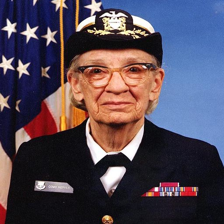

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [ ]:
type(grace_hopper)

PIL.Image.Image

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
type(grace_hopper)

numpy.ndarray

* TensorFlow models take input in the form of a NumPy array or a TensorFlow Tensor.

* Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction. So now grace_hopper numpy array has dimensions (1, height, width, channels)

*  When you have only one image to process but your model expects a batch, you create a batch with just that one image. This means adding an extra dimension to your single image tensor, changing its shape from [height, width, channels] to [1, height, width, channels]. Here, the 1 indicates that there is only one image in the batch.
The notation [np.newaxis, ...] is a convenient way in NumPy and TensorFlow to add this extra dimension. np.newaxis adds a new dimension of size 1 at the specified axis (at the start, in this case), and ... (ellipsis) is used to include all other existing dimensions.

* Why Use Batches?: Models are often trained on batches of images because it's more computationally efficient. It allows for parallel processing of multiple data points at once and takes advantage of GPU acceleration.

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 5s 5s/step


(1, 1001)

In [ ]:
print(result)
type(result)

[[ 0.1996763   1.0678949  -0.09609801 ...  0.1060295  -0.56031984
  -0.07089178]]


numpy.ndarray

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

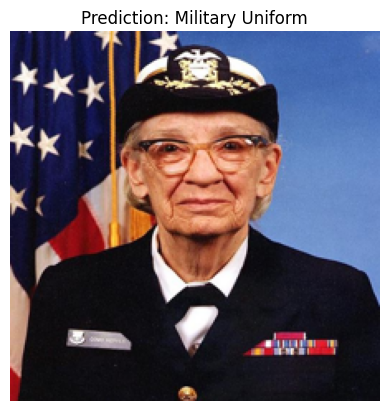

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Bingo. Our model correctly predicted military uniform!

# Cats vs. Dogs dataset

Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [ ]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

The images in the Dogs vs. Cats dataset are not all the same size.

In [ ]:
for i, example_image in enumerate(train_examples.take(3)):
  print(type(example_image))
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

<class 'tuple'>
Image 1 shape: (262, 350, 3)
<class 'tuple'>
Image 2 shape: (409, 336, 3)
<class 'tuple'>
Image 3 shape: (493, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

Our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.


In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 1s/step


array(['Egyptian cat', 'golden retriever', 'Egyptian cat', 'collie',
       'hamster', 'tabby', 'Labrador retriever', 'Border collie',
       'Egyptian cat', 'Greater Swiss Mountain dog', 'Egyptian cat',
       'Dandie Dinmont', 'beagle', 'tabby', 'Egyptian cat', 'Persian cat',
       'collie', 'groenendael', 'West Highland white terrier',
       'golden retriever', 'miniature schnauzer', 'tabby', 'papillon',
       'English foxhound', 'cocker spaniel', 'Weimaraner', 'Egyptian cat',
       'redbone', 'Border collie', 'Egyptian cat', 'Border collie',
       'Egyptian cat'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

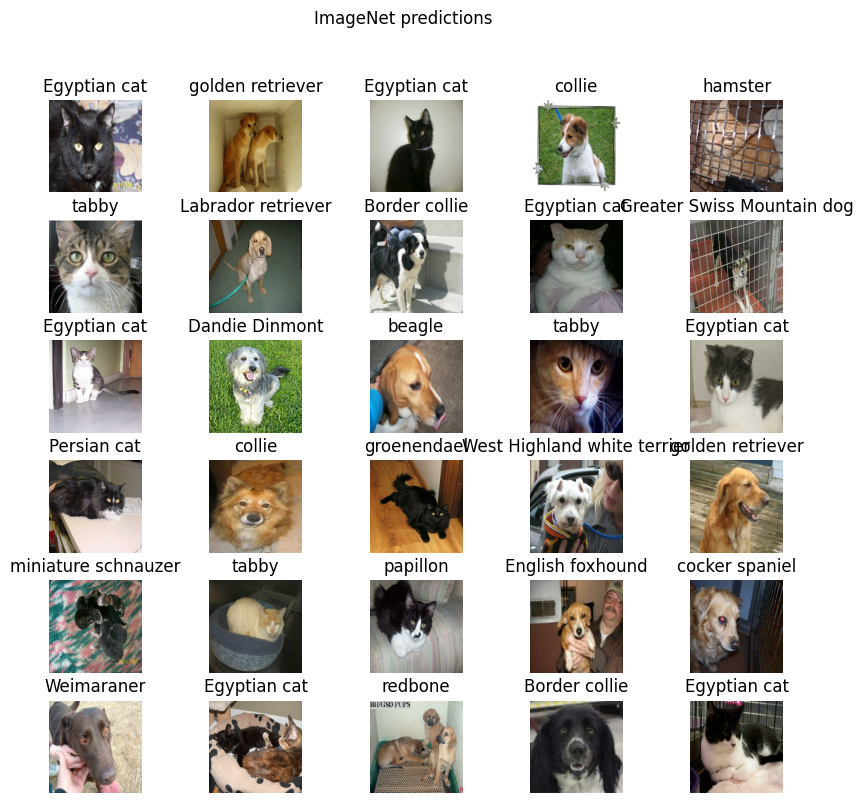

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning.

We'll use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution.
That is, it has extracted the features of the image and outputs a feature vector.

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

* `feature_extractor(image_batch)` : This line applies the feature extractor to `image_batch` which is an array of images. The feature extractor processes each image and outputs a corresponding feature vector.

* `feature_batch.shape` will be `(batch_size, number_of_features)` where`batch_size` is the number of images in `image_batch` and `number_of_features` is the length of the feature vector produced by MobileNet V2 for each image.

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [ ]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 47s 65ms/step - loss: 0.0542 - accuracy: 0.9820 - val_loss: 0.0343 - val_accuracy: 0.9886
Epoch 2/6
582/582 [==============================] - 45s 66ms/step - loss: 0.0304 - accuracy: 0.9891 - val_loss: 0.0344 - val_accuracy: 0.9886
Epoch 3/6
582/582 [==============================] - 42s 63ms/step - loss: 0.0251 - accuracy: 0.9919 - val_loss: 0.0327 - val_accuracy: 0.9886
Epoch 4/6
582/582 [==============================] - 42s 64ms/step - loss: 0.0212 - accuracy: 0.9927 - val_loss: 0.0336 - val_accuracy: 0.9899
Epoch 5/6
582/582 [==============================] - 42s 61ms/step - loss: 0.0188 - accuracy: 0.9930 - val_loss: 0.0360 - val_accuracy: 0.9890
Epoch 6/6
582/582 [==============================] - 42s 63ms/step - loss: 0.0172 - accuracy: 0.9940 - val_loss: 0.0471 - val_accuracy: 0.9854


You can see we get ~97% validation accuracy, which is absolutely awesome. The reason is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

Let's plot the training and validation accuracy/loss graphs.

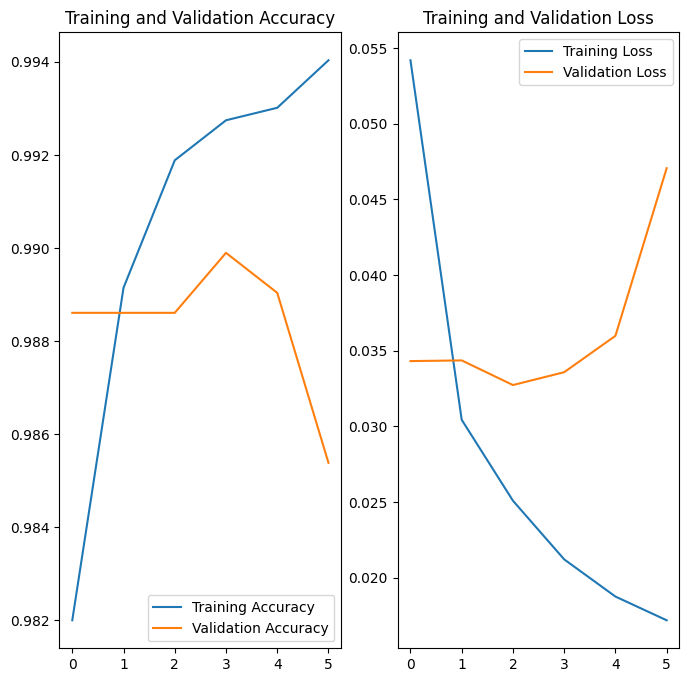

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

## Check the predictions

To redo the plot from before, first get the ordered list of class names.

In [ ]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 0s 469ms/step


array(['cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat',
       'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat',
       'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'dog', 'cat'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0]
Predicted labels:  [0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0]


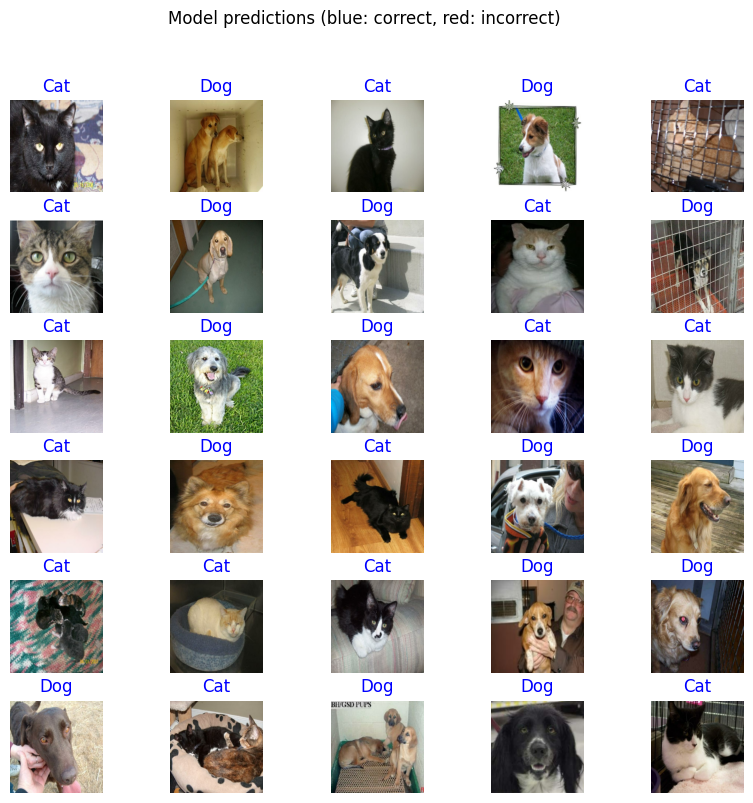

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")